# DSCI100-32: Star Classifiaction ⭐

## Introduction:

Star classification is an emerging field of research used to better understand the galaxies which surround us. Determining star types is vital in the research of extraterrestrial life, understanding stellar evolution, and predicting the future behaviour of our own sun. 
Our group will be working on the Star Dataset for Stellar Classification dataset from Kaggle. In the field of astronomy, star classification is based on a number of spectral characteristics, including apparent and absolute magnitude, spectral type, and colour index.

## Question:

We will use these predictors to calibrate whether we can correctly predict the chemical composition (spectral class) of an unknown star using the factors and information provided through the dataset.


In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
library(ggplot2)
install.packages('kknn')
#essential modules that are required in order to run most of our data analysis and given to us throughout DSCI100

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

In [2]:
colname = c("Vmag","distance","error_distance","color_index","spectral_type","Amag","Class")
stars <- read_csv("stars.csv", col_names = colname, skip = 1)
#Rewriting column names to more readable usages for overall data manipulation
stars

Rows: 3642 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): spectral_type
dbl (6): Vmag, distance, error_distance, color_index, Amag, Class

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Vmag,distance,error_distance,color_index,spectral_type,Amag,Class
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
5.99,13.73,0.58,1.318,K5III,16.67835,0
8.70,2.31,1.29,-0.045,B1II,15.51806,0
5.77,5.50,1.03,0.855,G5III,14.47181,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮
6.11,2.42,0.79,1.664,M0/M1IIICNp,13.02908,0
7.94,4.94,2.90,0.210,A5V,16.40864,1
8.81,1.87,1.23,1.176,K1/K2III,15.16921,0


In [3]:
stars <- stars |>
    mutate(spectral_type = case_when(grepl("K",spectral_type) ~ "K",
                                grepl("B",spectral_type) ~ "B", 
                                grepl("G",spectral_type) ~ "G", 
                                grepl("M",spectral_type) ~ "M", 
                                grepl("A",spectral_type) ~ "A",
                                grepl("F",spectral_type) ~ "F",
                                grepl("O",spectral_type) ~ "O",
                                grepl("C",spectral_type) ~ "C")) |>
    mutate(spectral_type = as_factor(spectral_type))
stars

Vmag,distance,error_distance,color_index,spectral_type,Amag,Class
<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>
5.99,13.73,0.58,1.318,K,16.67835,0
8.70,2.31,1.29,-0.045,B,15.51806,0
5.77,5.50,1.03,0.855,G,14.47181,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮
6.11,2.42,0.79,1.664,M,13.02908,0
7.94,4.94,2.90,0.210,A,16.40864,1
8.81,1.87,1.23,1.176,K,15.16921,0


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


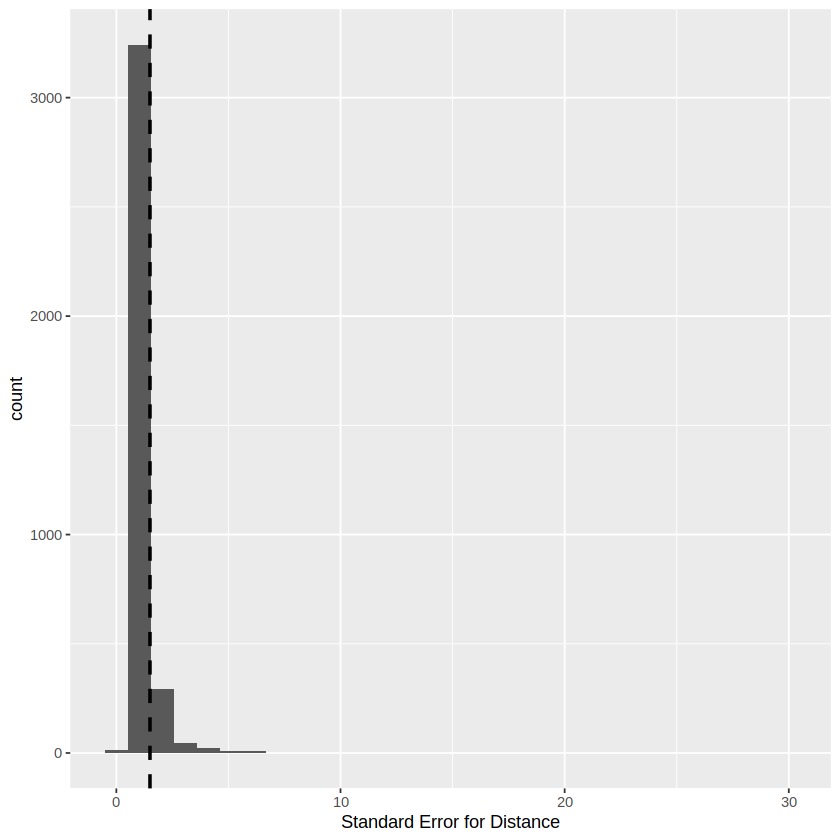

In [4]:
error_remove_plot <- stars |>
    ggplot(aes(x = error_distance)) + 
    geom_histogram() +
    geom_vline(xintercept = 1.50, linetype = "dashed", linewidth = 1) +
    xlab("Standard Error for Distance")


error_remove_plot
# this plot shows the number of error values for the distance. The values left of the vertical line 
# will be kept and the values to the right will be discarded.


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


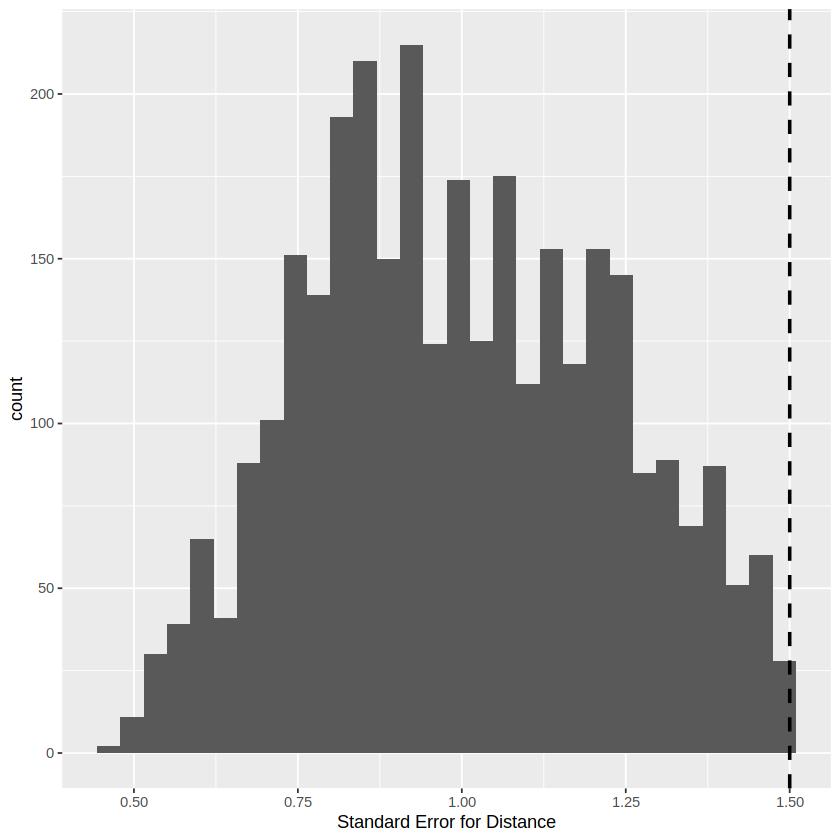

In [5]:
final_error_plot <- stars |>
    filter(error_distance < 1.50) |>
    ggplot(aes(x = error_distance)) + 
    geom_histogram() +
    geom_vline(xintercept = 1.50, linetype = "dashed", linewidth = 1) +
    xlab("Standard Error for Distance")

final_error_plot

The dataset will be adjusted according to the information found above 
After the error distance is used to remove data points, the column has no further use.

In [6]:
stars <- stars |>
    filter(error_distance < 1.50)|>
    select( Vmag, distance, color_index, spectral_type, Amag ,Class)

stars

Vmag,distance,color_index,spectral_type,Amag,Class
<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>
5.99,13.73,1.318,K,16.67835,0
8.70,2.31,-0.045,B,15.51806,0
5.77,5.50,0.855,G,14.47181,0
⋮,⋮,⋮,⋮,⋮,⋮
8.29,6.38,0.408,F,17.31410,1
6.11,2.42,1.664,M,13.02908,0
8.81,1.87,1.176,K,15.16921,0


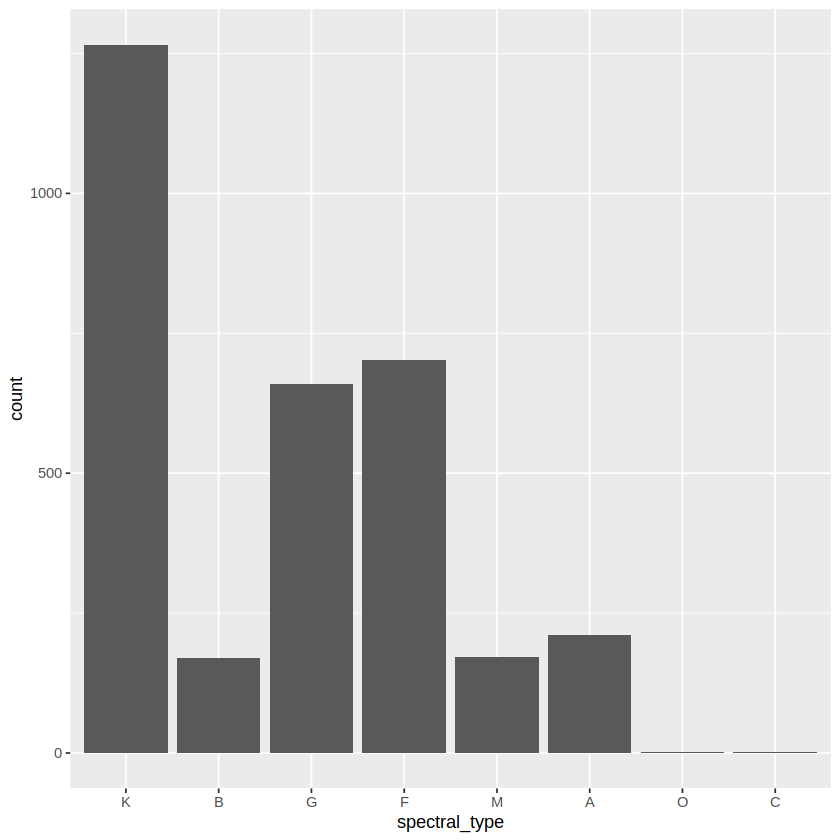

In [7]:
spectral_plot <- stars |>
    ggplot(aes(x = spectral_type)) + 
    geom_bar() 

spectral_plot

As shown in the Figure above, there are a very limited number of observations with the spectral type O and C. Due to this, these types will be removed. 

In [8]:
stars <- stars |>
    filter( spectral_type != "O", spectral_type != "C")

stars  

Vmag,distance,color_index,spectral_type,Amag,Class
<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>
5.99,13.73,1.318,K,16.67835,0
8.70,2.31,-0.045,B,15.51806,0
5.77,5.50,0.855,G,14.47181,0
⋮,⋮,⋮,⋮,⋮,⋮
8.29,6.38,0.408,F,17.31410,1
6.11,2.42,1.664,M,13.02908,0
8.81,1.87,1.176,K,15.16921,0


With this, our data set is tidy and ready to be used for our purposes.

In [9]:
set.seed(2000)

star_split <- initial_split(stars, prop = 0.75, strata = spectral_type)
star_train <- training(star_split)
star_test <- testing(star_split) 

In [10]:
class_count <- star_train|>
    select(Class)|>
    group_by(Class)|>
    count(Class)

class_count

Class,n
<dbl>,<int>
0,1291
1,1093


This table represents the number of observations in our training data that are classified as Dwarfs (0) or Giants (1)

In [11]:
predictor_means <- star_train |>
    select(Vmag:color_index, Amag, Class) |>
    map_df(mean)

predictor_means

Vmag,distance,color_index,Amag,Class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
7.923872,7.668507,0.8513721,16.25542,0.4584732


This table shows the mean of all the predictors that can be used.

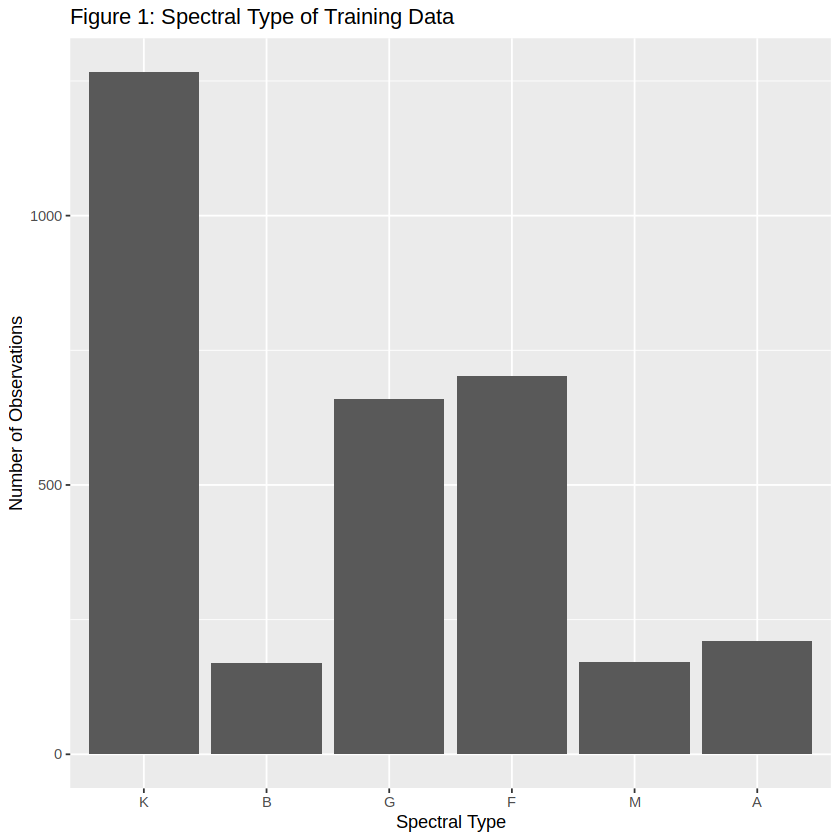

In [12]:
spectral_training_plot <- stars |>
    ggplot(aes(x = spectral_type)) + 
    geom_bar() +
    labs(x = "Spectral Type", y = "Number of Observations") +
    ggtitle("Figure 1: Spectral Type of Training Data")
    

spectral_training_plot

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


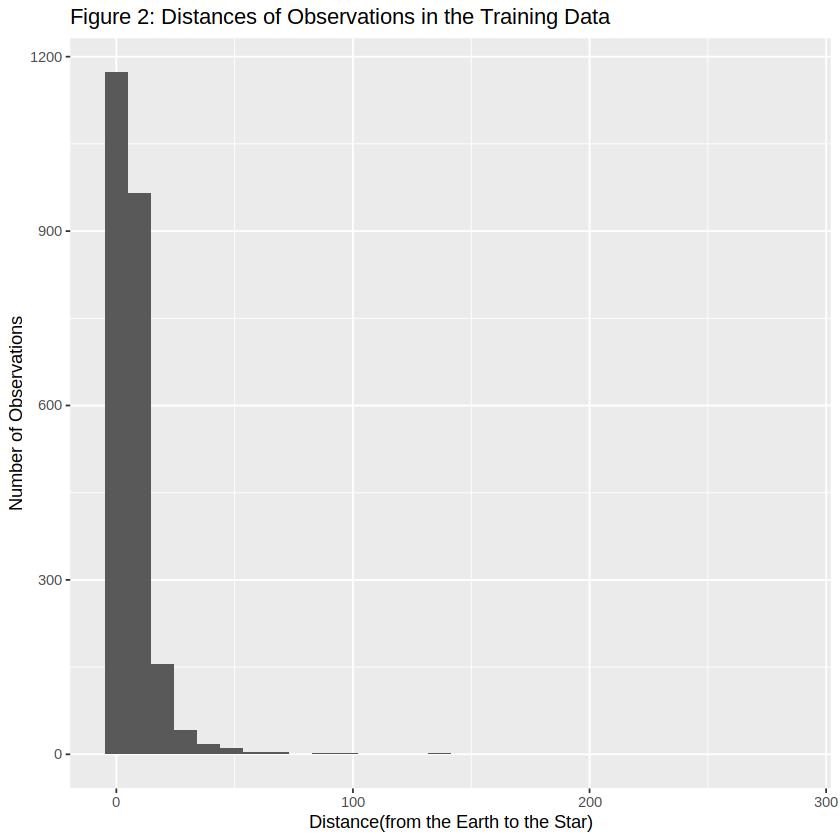

In [13]:
distance_training_plot <- star_train |>
    ggplot(aes(x = distance)) + 
    geom_histogram() +
    labs(x = "Distance(from the Earth to the Star)", y = "Number of Observations") +
    ggtitle("Figure 2: Distances of Observations in the Training Data")
    
distance_training_plot


spectral_training_plot <- stars |>
    ggplot(aes(x = spectral_type)) + 
    geom_bar() +
    labs(x = "Spectral Type", y = "Number of Observations") +
    ggtitle("Figure 1: Spectral Type of Training Data")
    
## Methods:

We will be using the columns vMag (visual apparent magnitude), Plx (distance between the Star and Earth), B-V (spectral colour index), and targetclass (Giant or Dwarf), to predict SpType (spectral type) - of a new observation. Amag(absolute magnitude) was excluded in this set of predictors as it is not an observed value.  Our process will involve obtaining a trend line from KNN regression and deriving a function for it. We will also utilise KNN classification. We will be using a scatter plot from the package ggplot2 for KNN, and a histogram for depicting how the data is spread amongst the target classes. 
Using the B-V colour index, we are also able to derive a star’s spectral type and classify it between a multitude of star classes from white dwarves to hypergiants based on their luminosity class and a number of other factors.
Given the correct spectral type through the dataset’s columns, we can use the information already present in the graph to predict future stars that have not yet had their spectral types assigned by using other properties present within the chart to help further train our predictions.


## Expected Outcomes and Significance:

If we can derive the identity of a Spectral Class of a star, chemists could be able to examine the cosmic age of the star and approximate the period of time until which a star depletes its chemical reactants and either burns out or becomes a supernova.

! Fold1: internal:
  There were 9 warnings in `dplyr::summarise()`.
  The first warning was:
  ℹ In argument: `.estimate = metric_fn(...)`.
  ℹ In group 1: `neighbors = 2`.
  Caused by warning:
  ! No observations were detected in `truth` for level(s): 'O', 'C'
  Computation will proceed by ignoring those levels.
  ℹ Run `dplyr::last_dplyr_warnings()` to see the 8 r...

! Fold2: internal:
  There were 9 warnings in `dplyr::summarise()`.
  The first warning was:
  ℹ In argument: `.estimate = metric_fn(...)`.
  ℹ In group 1: `neighbors = 2`.
  Caused by warning:
  ! No observations were detected in `truth` for level(s): 'O', 'C'
  Computation will proceed by ignoring those levels.
  ℹ Run `dplyr::last_dplyr_warnings()` to see the 8 r...

! Fold3: internal:
  There were 9 warnings in `dplyr::summarise()`.
  The first warning was:
  ℹ In argument: `.estimate = metric_fn(...)`.
  ℹ In group 1: `neighbors = 2`.
  Caused by warning:
  ! No observations were detected in `truth` for level(s): '

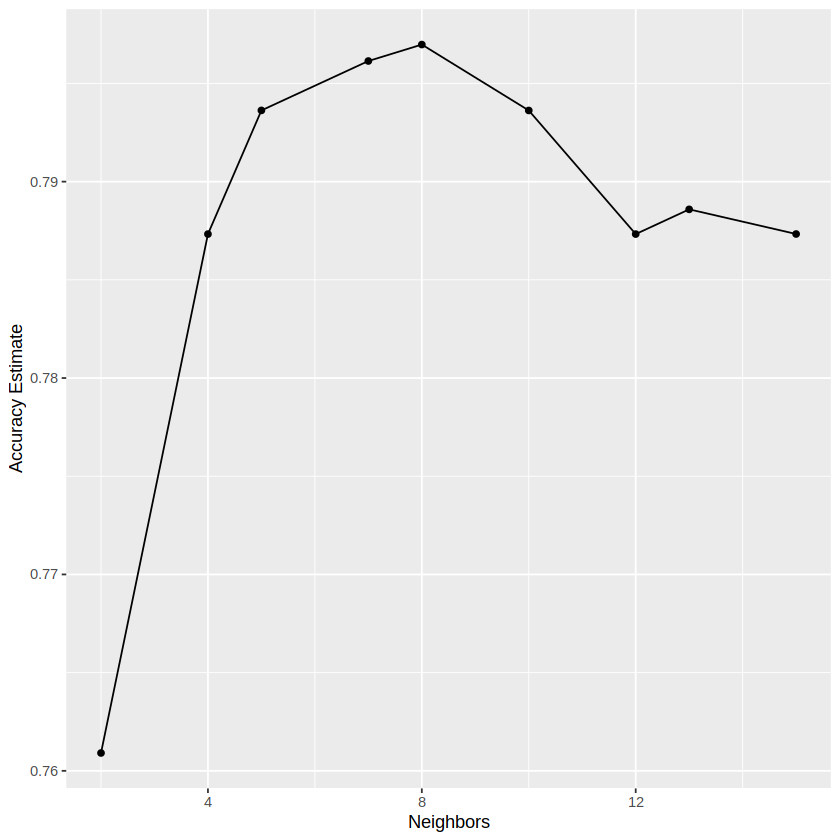

In [14]:
star_vfold <- vfold_cv(star_train, v = 5, strata = spectral_type)

star_recipe <- star_train |>
    recipe(spectral_type ~ Vmag + distance + color_index + Class) |>
    step_center(all_predictors()) |>
    step_scale(all_predictors())

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

star_tuning_fit <- workflow() |>
    add_recipe(star_recipe) |>
    add_model(knn_tune) |>
    tune_grid(resamples = star_vfold, grid = 10) |>
    collect_metrics()

accuracies <- star_tuning_fit |>
    filter(.metric == "accuracy")

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") 

accuracy_versus_k


Judging from the plot above, it would be optimal to use 8 neighbors.

In [15]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 8) |>
    set_engine("kknn") |>
    set_mode("classification")

star_fit <- workflow() |>
       add_recipe(star_recipe) |>
       add_model(knn_spec) |>
       fit(data = star_train)
star_fit



══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_center()
• step_scale()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(8,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.1979866
Best kernel: rectangular
Best k: 8

In [16]:
star_test_prediction <- predict(star_fit , star_test) |>
       bind_cols(star_test)

star_test_prediction

.pred_class,Vmag,distance,color_index,spectral_type,Amag,Class
<fct>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>
F,7.57,8.67,0.528,F,17.26010,1
M,7.58,3.47,1.626,M,15.28165,0
A,8.27,1.62,0.146,B,14.31757,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮
F,8.81,5.71,0.512,F,17.59318,1
A,7.23,4.91,0.010,A,15.68541,1
K,6.64,4.46,1.301,K,14.88668,0


In [17]:
star_prediction_accuracy <- star_test_prediction |>
         metrics(truth = spectral_type, estimate = .pred_class)  
star_prediction_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.7874214
kap,multiclass,0.7106314
